In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
def onehotkey(X): 
    integer_encoded = LabelEncoder().fit_transform(X)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = OneHotEncoder(sparse=False).fit_transform(integer_encoded)
    return onehot_encoded

In [4]:
# compute the xent loss 
def ent(p):
    if p>1 or p<0: return('Not Probability')
    elif p==0 or p==1: return (0) 
    else: return -(p*np.log(p)+(1-p)*np.log(1-p))
    
# Data: (x4,x10)= four possibilities: Prob(y=1, x4, x10)
# (1,1) -> p(y=1)=0.65
# (0,1) -> p(y=1)=0.25
# (1,0) -> p(y=1)=0.45
# (0,0) -> p(y=1)=0.10 

# The question is: does the machine has the capability to probe the details to this level? 
# If not capable of probing x10 dependence, then x10 is essentially a hidden variable 
#    whose influence needs to be summer over (marginalized), so we have
#    p(y=1,x4) = sum_x10 p(y=1,x4,x10) = (0.65+0.45)/2 = 0.55 
# If not capable of probing neither x4 or x10, we need to sum over both (as if both were hidden units)
#    so we have p(y=1)= sum_x10,x4 p(y=1,x4,x10) = (0.65+0.25+0.40+0.10)/4 = 0.35 

# Got both x10 and x4

plist = [0.65,0.25,0.45,0.10]
print ("B: Xent Loss ", sum(ent(p) for p in plist)/len(plist))

# Got only x4
plist = [0.55, 0.175]
print ("F: Xent Loss ", sum(ent(p) for p in plist)/len(plist))

# Got none
plist = [(0.65+0.25+0.40+0.10)/4]
print ("N: Xent Loss ", sum(ent(p) for p in plist)/len(plist))

B: Xent Loss  0.5557508926896193
F: Xent Loss  0.5759326267664994
N: Xent Loss  0.6474466390346325


In [5]:
tf.reset_default_graph()
np.random.seed(2)
tf.set_random_seed(2)

# Configuration on Global Variables
# 1. RNN Cell Configuration (normally num_neuron = state_size, but not necessary)
#num_neuron = 10

# 2. Recurrent Steps (Unfolding)
num_steps = 25 # number of truncated backprop steps ('n' in the discussion above)
pos_1=3
pos_2=20

# 3. Data Input/State/Output 
seq_size =   20000000
#seq_size = 200000000
state_size = 100
num_classes = 2 

# 4. Training (Mini-Batch, LearningRate, Dropout, ...)
batch_size = 400
learning_rate = 0.3

In [6]:
def gen_batch(seq_size, batch_size, num_steps): 
    X = np.random.choice([0,1], p=[0.5,0.5], size=seq_size)   
    pos1=4
    pos2=40
    plist=[0.65, 0.45, 0.25, 0.10]
    p2=np.zeros((2, 2))
    p2[1,1]=plist[0]
    p2[1,0]=plist[1]
    p2[0,1]=plist[2]
    p2[0,0]=plist[3]

    X = np.random.choice([0,1], p = [0.5, 0.5], size = seq_size)
    Prob = p2[np.roll(X,pos1), np.roll(X,pos2)]
    Y = (np.random.rand(len(X)) < Prob).astype(int)
    
    epoch_size = seq_size // (batch_size*num_steps)
    
    X.resize(batch_size, epoch_size, num_steps)
    Y.resize(batch_size, epoch_size, num_steps)
    
    for i in range(epoch_size):
        yield (X[:,i,:],Y[:,i,:])

In [7]:
# Input and Output_labeling (turn everything into a list for handling)
# num_class is assumed to be the same for input and output (not necessary)
# run_inputs list of num_steps tensors with shape [batch_size, num_classes]
# initial state 

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

rnn_inputs = tf.one_hot(x, num_classes)
print("rnn_inputs", rnn_inputs.get_shape())


cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state, dtype="float32")

print("rnn_output", rnn_outputs.get_shape())
print("final_state", final_state.get_shape())

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))


logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes])
print("logits", logits.get_shape())

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)


rnn_inputs (400, 25, 2)
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
rnn_output (400, 25, 100)
final_state (400, 100)
logits (400, 25, 2)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Step & Loss:  200 1.3797454246878624
Step & Loss:  400 0.5942327061295509
Step & Loss:  600 0.5803773182630539
Step & Loss:  800 0.5766353461146355
Step & Loss:  1000 0.576211154460907
Step & Loss:  1200 0.5763591688871383
Step & Loss:  1400 0.5756925541162491
Step & Loss:  1600 0.5763954567909241
Step & Loss:  1800 0.576006421148777
Num of Unfolding (num_steps)  25
Num of Neurons in RNN Cell (state_size)  100
Sequence Length(seq_size)  20000000
Batch,Steps,Epoch  400 25 2000


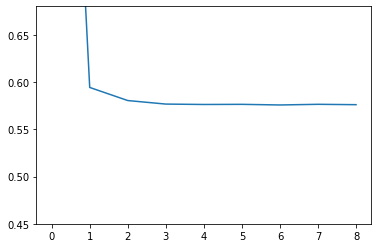

In [8]:
# Training the network 
def train_network(seq_size, num_steps, state_size, printout=10):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
               
        training_loss = 0
        training_state = np.zeros((batch_size, state_size))
        step = 0

        for (X, Y) in gen_batch(seq_size, batch_size, num_steps):
            training_loss_, training_state, _ = \
                sess.run([total_loss, final_state, train_step],
                              feed_dict={x:X, y:Y, init_state:training_state})
            training_loss += training_loss_
            if step % printout == 0 and step > 0:
                print("Step & Loss: ", step, training_loss/printout)
                training_losses.append(training_loss/printout)
                training_loss = 0
            step +=1
                
    return training_losses

training_losses = train_network(seq_size,num_steps,state_size, printout=200)
print('Num of Unfolding (num_steps) ', num_steps)
print('Num of Neurons in RNN Cell (state_size) ', state_size)
print('Sequence Length(seq_size) ', seq_size)
print('Batch,Steps,Epoch ', batch_size, num_steps, seq_size//(batch_size*num_steps))
plt.ylim(0.45, 0.68)
plt.plot(training_losses)

In [9]:
training_losses


[1.3797454246878624,
 0.5942327061295509,
 0.5803773182630539,
 0.5766353461146355,
 0.576211154460907,
 0.5763591688871383,
 0.5756925541162491,
 0.5763954567909241,
 0.576006421148777]